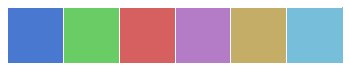

In [100]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
py.sign_in('glemaitre', 'se04g0bmi2')

import mpld3

import seaborn as sns; sns.set()
sns.palplot(sns.color_palette("muted"))

import numpy as np

from scipy.stats import norm,rayleigh,rice
from scipy.optimize import curve_fit
from scipy.stats.mstats import mode

## Load the data

Impor the mat containing the gray levels information

In [2]:
from scipy.io import loadmat

matfiles = loadmat('../data/mat/all_voxels.mat');

data = np.asmatrix(matfiles['data'])
data = data.astype(float)
label = np.ravel(matfiles['label'])
patient_sizes = np.ravel(matfiles['patient_sizes'])

Load only the dce dataset

In [3]:
data_dce = np.asmatrix(data[:, 3:-1])

Create a class Patient to facilitate data management.

The data are the DCE and this sequence is composed of multiple series. Thus, there is a need to compute information for each serie composing the DCE:

* the minimum intensity of the serie,
* the maximum intensity of the serie,
* the pdf of the serie,
* the mean of the serie,
* the std of the serie,
* the parameters of a Gaussian fitting on the distribution.

In [109]:
class Patient(object):
    def __init__(self, data):
        self.data = data.copy()
        # Allocation of the minimum and maximum array for the series
        self.max_int_serie = []
        self.min_int_serie = []
        # Allocate the pdf and the bin_edges
        self.pdf_serie = []
        self.bin_edges_serie = []
        # Allocate the mean and std of the data
        self.mean_data_serie = []
        self.median_data_serie = []
        self.std_data_serie = []
        self.gaussian_params_serie = []
        self.idx_mean = []
        self.idx_median = []
        self.mode_data_serie = []
        for serie in range(data.shape[1]):
            # Find the minimum and maximum for the given serie
            self.max_int_serie.append(np.max(self.data[:, serie]))
            self.min_int_serie.append(np.min(self.data[:, serie]))
            # Compute the histogram
            pdf, bin_edges = np.histogram(self.data[:, serie],
                                                    bins = (self.max_int_serie[-1] - self.min_int_serie[-1]),
                                                    density=True)
            # Append the histogram
            self.pdf_serie.append(pdf)
            self.bin_edges_serie.append(bin_edges)
        
            self.mean_data_serie.append(np.mean(self.data[:, serie]))
            self.std_data_serie.append(np.std(self.data[:, serie]))
            self.median_data_serie.append(np.ravel(np.median(self.data[:, serie], axis=0)))
            tmp_mode, tmp_idx = mode(self.data[:, serie], axis=None)
            self.mode_data_serie.append(np.ravel(tmp_mode)[0])
            
            print serie
            print self.mode_data_serie
            
            # Find the index of the mean and the median for this serie
            ##### WRONG
            def argmean(x):
                x_mean = np.mean(np.ravel(x))
                return (np.abs(x-x_mean)).argmin()
            
            def argmedian(x):
                x_median = np.median(np.ravel(x))
                return (np.abs(x-x_median)).argmin()
            
            self.idx_mean.append([serie, argmean(self.data[:, serie])])
            self.idx_median.append([serie, argmedian(self.data[:, serie])])
       
            # Fit a gaussian distribution to get mean and std
            self.gaussian_params_serie.append(norm.fit(self.data[:, serie]))

In [110]:
#Build an histogram for each patient
patient_list = [];
for pt in range(np.size(patient_sizes)):

    if (pt == 0):
        start_idx = 0
        end_idx = patient_sizes[pt] - 1
    else:
        start_idx = np.sum(patient_sizes[0 : pt])
        end_idx = np.sum(patient_sizes[0 : pt + 1]) - 1
        
    # Create the patient data
    patient_list.append(Patient(data_dce[start_idx : end_idx]))

0
[185.0]
1
[185.0, 186.0]
2
[185.0, 186.0, 180.0]
3
[185.0, 186.0, 180.0, 213.0]
4
[185.0, 186.0, 180.0, 213.0, 186.0]
5
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0]
6
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0]
7
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0]
8
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0]
9
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0]
10
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0, 223.0]
11
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0, 223.0, 256.0]
12
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0, 223.0, 256.0, 268.0]
13
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0, 223.0, 256.0, 268.0, 251.0]
14
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0, 223.0, 256.0, 268.0, 251.0, 293.0]
15
[185.0, 186.0, 180.0, 213.0, 186.0, 199.0, 169.0, 214.0, 239.0, 220.0, 223.0, 256.0, 268.0, 251.0, 293.0, 3

## By patient analysis

We can make a by patient analysis in order to perform the normalisation. We will first start with some visualisation.

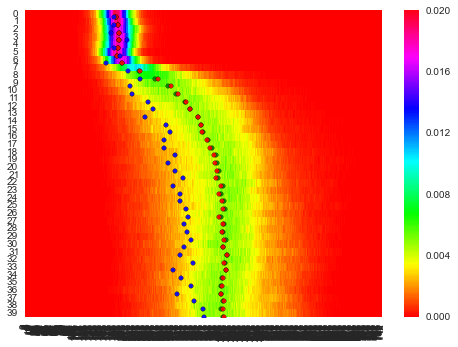

In [111]:
# Define the index of the patient to visualise
pat_vis = 0

pat_heatmap = []
#for pat_vis in range(len(patient_list)):

# Allocate the heatmap
### Find the maximum and minimum from all series
pt_min_intensity = min(patient_list[pat_vis].min_int_serie)
pt_max_intensity = max(patient_list[pat_vis].max_int_serie)
### Allocate the heat map with the right indexing
heatmap_z_raw = np.zeros((len(patient_list[pat_vis].pdf_serie),
                                      int(pt_max_intensity)));

heatmap_y = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    str_pt = 'Serie ' + str(s) + ' '
    heatmap_y.append(str_pt)
    heatmap_z_raw[s, range(int(patient_list[pat_vis].min_int_serie[s]),
                           int(patient_list[pat_vis].max_int_serie[s]))] = patient_list[pat_vis].pdf_serie[s]

stat_median = np.ravel(patient_list[pat_vis].median_data_serie).astype(int)
stat_mean = np.ravel(patient_list[pat_vis].mean_data_serie).astype(int)
    
ax = sns.heatmap(heatmap_z_raw, cmap="hsv")
sns.plt.scatter(np.ravel(patient_list[pat_vis].median_data_serie), np.arange(39, -1, -1), label='mean', c='green', alpha=0.9)
sns.plt.scatter(np.ravel(patient_list[pat_vis].mean_data_serie), np.arange(39, -1, -1), label='median', c='red', alpha=0.9)
sns.plt.scatter(np.ravel(patient_list[pat_vis].mode_data_serie), np.arange(39, -1, -1), label='median', c='blue', alpha=0.9)

from skimage.graph import route_through_array

# Define the starting and ending seeds
start = [0, stat_median[0]]
end = [39, stat_median[-1]]

# Compute the inverse image
image = 1. - (heatmap_z_raw / np.max(heatmap_z_raw))

# Find the shortest path
indices, weight = route_through_array(image, start, end, geometric=False)
indices = np.array(indices).T
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1

#sns.plt.scatter(indices[1], np.abs(indices[0]-39), label='mean', c='blue', alpha=0.9)

#plot_data = Data([Heatmap(z=heatmap_z_raw, y=heatmap_y, colorscale='Jet')])
#layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
#plot_data = Data(pat_heatmap)
# Define a figure
#fig = Figure(data=plot_data)
#py.iplot(fig, filename='heatmap-dce')

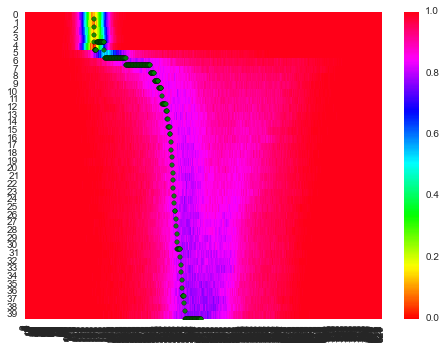

In [89]:
from skimage.graph import route_through_array

# Define the starting and ending seeds
start = [0, stat_median[0]]
end = [39, stat_median[-1]]

# Compute the inverse image
image = 1. - (heatmap_z_raw / np.max(heatmap_z_raw))

# Find the shortest path
indices, weight = route_through_array(image, start, end)
indices = np.array(indices).T
path = np.zeros_like(image)
path[indices[0], indices[1]] = 1

ax = sns.heatmap(image, cmap="hsv")
sns.plt.scatter(indices[1], np.abs(indices[0]-39), label='mean', c='green', alpha=0.9)

In [234]:
# Define the index of the patient to visualise
pat_vis = 0

pat_heatmap = []
#for pat_vis in range(len(patient_list)):

# Allocate the heatmap
### Find the maximum and minimum from all series
pt_min_intensity = min(patient_list[pat_vis].min_int_serie)
pt_max_intensity = max(patient_list[pat_vis].max_int_serie)
### Allocate the heat map with the right indexing
heatmap_z_raw = np.zeros((len(patient_list[pat_vis].pdf_serie),
                                      int(pt_max_intensity)));

heatmap_y = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    str_pt = 'Serie ' + str(s) + ' '
    heatmap_y.append(str_pt)
    heatmap_z_raw[s, range(int(patient_list[pat_vis].min_int_serie[s]),
                           int(patient_list[pat_vis].max_int_serie[s]))] = patient_list[pat_vis].pdf_serie[s]
        
plot_data = Data([Heatmap(z=heatmap_z_raw, y=heatmap_y, colorscale='Jet')])
#layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
#plot_data = Data(pat_heatmap)
# Define a figure
fig = Figure(data=plot_data)
py.iplot(fig, filename='heatmap-dce')

In [236]:
serie_pdf = []
for ind, serie in enumerate(patient_list[pat_vis].pdf_serie):
    serie_pdf.append(np.squeeze(np.asarray(heatmap_z_raw[ind,:])))

### Correction using only the mean and std

In [237]:
for s in range(len(patient_list[pat_vis].pdf_serie)):
    # Create the normalized data
    patient_list[pat_vis].data[:, s] = np.round(patient_list[pat_vis].data[:, s] - (patient_list[pat_vis].median_data_serie[s]))
    # Recompute the pdf
    # Find the minimum and maximum for the given serie
    patient_list[pat_vis].max_int_serie[s] = np.max(patient_list[pat_vis].data[:, s])
    patient_list[pat_vis].min_int_serie[s] = np.min(patient_list[pat_vis].data[:, s])
    # Compute the histogram
    pdf, bin_edges = np.histogram(patient_list[pat_vis].data[:, s],
                                  bins = int(np.round((patient_list[pat_vis].max_int_serie[s] - patient_list[pat_vis].min_int_serie[s]))), 
                                  density=True)
    # Append the histogram
    patient_list[pat_vis].pdf_serie[s] = pdf
    patient_list[pat_vis].bin_edges_serie[s] = bin_edges

We can show the data with median shifted

In [238]:
pat_heatmap = []
#for pat_vis in range(len(patient_list)):

# Allocate the heatmap
### Find the maximum and minimum from all series
pt_min_intensity = np.abs(min(patient_list[pat_vis].min_int_serie))
pt_max_intensity = np.abs(min(patient_list[pat_vis].min_int_serie)) + max(patient_list[pat_vis].max_int_serie)
### Allocate the heat map with the right indexing
heatmap_z_raw = np.zeros((len(patient_list[pat_vis].pdf_serie), int(pt_max_intensity)))

heatmap_y = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    str_pt = 'Serie ' + str(s) + ' '
    heatmap_y.append(str_pt)
    
    arr_sz = int(np.abs(patient_list[pat_vis].min_int_serie[s]) + patient_list[pat_vis].max_int_serie[s])
    offset = pt_min_intensity - np.abs(patient_list[pat_vis].min_int_serie[s])
    r = range(int(offset), arr_sz+int(offset))
        
    heatmap_z_raw[s, r] = patient_list[pat_vis].pdf_serie[s]
        
plot_data = Data([Heatmap(z=heatmap_z_raw, y=heatmap_y, colorscale='Jet')])
#layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
#plot_data = Data(pat_heatmap)
# Define a figure
fig = Figure(data=plot_data)
py.iplot(fig, filename='heatmap-dce')

We can plot the variation of the std over time

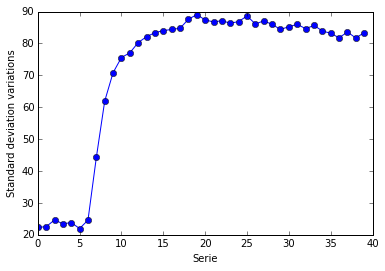

In [239]:
plt.figure()
plt.plot(patient_list[pat_vis].std_data_serie, 'o-')
plt.xlabel('Serie')
plt.ylabel('Standard deviation variations')
plt.show()

# Not useful for the moment

For a single patient we will start to fit a rician distrubution for each dce serie.

#### Define the function to fit

In [69]:
from collections import namedtuple

# For the Rician
def myRice(x, factor, v, shift, std):
    return rice.pdf(x, v, shift, std) / factor

# Define the parameters for the Rician
riceParameters = namedtuple('riceParameters',
                            ['factor', 'v', 'shift', 'std'])

# For the Gaussian
def myGaussian(x, factor, mean, std):
    return norm.pdf(x, mean, std) / factor

# Define the parameters for the Gaussian
gaussianParameters = namedtuple('gaussianParameters',
                                ['factor', 'mean', 'std'])

#### Fit the distribution of one patient

In [70]:
db_max_intensity = max(patient_list[pat_vis].max_int_serie)
db_min_intensity = min(patient_list[pat_vis].min_int_serie)

# Get the initial guess for the rician distribution
def get_rice_initial_parameters(patient, pdf, serie):
    
    # Get the mean from the patient information
    v = patient.mean_data_serie[serie] / db_max_intensity
    std = patient.std_data_serie[serie] / db_max_intensity
    factor = db_max_intensity
    
    # Compute the cumulative sum of the pdf
    cdf = np.cumsum(pdf)
    loc = float(np.argmax(cdf > .01)) / db_max_intensity
    #loc = np.argmax(cdf > .01)/db_max_intensity
    
    return riceParameters(factor, v, loc, std)

# For each serie get the initial parameter
rice_init = [get_rice_initial_parameters(patient_list[pat_vis], pdf, s) for s, pdf in enumerate(serie_pdf)]
rice_fitted_param = []
rice_fiting_error = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    popt, pcov = curve_fit(myRice,
                           np.linspace(0, 1., len(np.squeeze(np.asarray(heatmap_z_raw[s, :])))),
                           np.squeeze(np.asarray(heatmap_z_raw[s, :])),
                           p0=(rice_init[s].factor, rice_init[s].v,
                               rice_init[s].shift, rice_init[s].std),
                           maxfev=10000)
    rice_fitted_param.append(riceParameters(popt[0], popt[1], popt[2], popt[3],))
    rice_fiting_error.append(pcov)
    
# Get the initial guess for the rician distribution
def get_gaussian_initial_parameters(patient, pdf, serie):
    
    # Get the mean from the patient information
    mean = patient.mean_data_serie[serie] / db_max_intensity
    std = patient.std_data_serie[serie] / db_max_intensity
    factor = db_max_intensity
        
    return gaussianParameters(factor, mean, std)

# For each serie get the initial parameter
gaussian_init = [get_gaussian_initial_parameters(patient_list[pat_vis], pdf, s) for s, pdf in enumerate(serie_pdf)]
gaussian_fitted_param = []
gaussian_fiting_error = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    popt, pcov = curve_fit(myGaussian,
                           np.linspace(0, 1., len(np.squeeze(np.asarray(heatmap_z_raw[s, :])))),
                           np.squeeze(np.asarray(heatmap_z_raw[s, :])),
                           p0=(gaussian_init[s].factor, gaussian_init[s].mean, gaussian_init[s].std),
                           maxfev=10000)
    gaussian_fitted_param.append(gaussianParameters(popt[0], popt[1], popt[2],))
    gaussian_fiting_error.append(pcov)

ValueError: x and y must have same first dimension

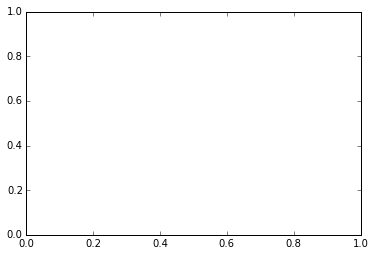

In [71]:
def output_msg(init, fitted):
    output_line = "{0:24s} ---> {1}:{2}\n"
    msg = "\n    initialization \t\t fitted\n"
    for param_name in riceParameters._fields:
        msg = msg+(output_line.format(
            param_name+': '+eval('"{0}".format(init.'+'{0:s}'.format(param_name)+')'),
            param_name,
            eval('"{0}".format(fitted.'+'{0:s}'.format(param_name)+')')))
    return msg

for s in range(len(patient_list[pat_vis].pdf_serie)):
       
    plt.figure()
    x = np.linspace(0, 1., int(db_max_intensity))
    plt.plot(x, np.squeeze(np.asarray(heatmap_z_raw[s, :])), label='data')
    
    plt.plot(x, myRice(x,
                       rice_fitted_param[s].factor,
                       rice_fitted_param[s].v,
                       rice_fitted_param[s].shift,
                       rice_fitted_param[s].std), label='rician')
    plt.plot(x, myGaussian(x,
                           gaussian_fitted_param[s].factor,
                           gaussian_fitted_param[s].mean,
                           gaussian_fitted_param[s].std), label='gaussian')
    plt.legend()
    plt.show()

#### Estimation of the mean for each PDF

In [36]:
for s in range(len(patient_list[pat_vis].pdf_serie)):
    if np.isnan(rice.mean(rice_fitted_param[s].v,
                       rice_fitted_param[s].shift,
                       rice_fitted_param[s].std)):
        print 'Mean using Gaussian estimation: {}'.format(norm.mean(gaussian_fitted_param[s].mean,
                                                                    gaussian_fitted_param[s].std))
    else:
        print 'Mean using Rician estimatation: {}'.format(rice.mean(rice_fitted_param[s].v,
                                                                    rice_fitted_param[s].shift,
                                                                    rice_fitted_param[s].std))
        print 'Mean using Gaussian estimation: {}'.format(norm.mean(gaussian_fitted_param[s].mean,
                                                                    gaussian_fitted_param[s].std))
    print ''

Mean using Rician estimatation: 0.235249430249
Mean using Gaussian estimation: 0.235128514574

Mean using Gaussian estimation: 0.233706965109

Mean using Rician estimatation: 0.230300582689
Mean using Gaussian estimation: 0.229817084552

Mean using Rician estimatation: 0.24055771063
Mean using Gaussian estimation: 0.240215706699

Mean using Gaussian estimation: 0.243843489819

Mean using Rician estimatation: 0.29975353096
Mean using Gaussian estimation: 0.287317770267

Mean using Rician estimatation: 0.421944698528
Mean using Gaussian estimation: 0.3993176862

Mean using Rician estimatation: 0.488856513759
Mean using Gaussian estimation: 0.480699804223

Mean using Gaussian estimation: 0.501099064295

Mean using Gaussian estimation: 0.514980670858

Mean using Gaussian estimation: 0.517933951738

Mean using Gaussian estimation: 0.519709620571

Mean using Gaussian estimation: 0.531898485628

Mean using Gaussian estimation: 0.53999639831

Mean using Gaussian estimation: 0.538318208851

Mea

#### Correct the mean offset

In [51]:
for s in range(len(patient_list[pat_vis].pdf_serie)):
    # Estimate the mean as previously presented
    if np.isnan(rice.mean(rice_fitted_param[s].v,
                       rice_fitted_param[s].shift,
                       rice_fitted_param[s].std)):
        mean_corr = norm.mean(gaussian_fitted_param[s].mean,
                      gaussian_fitted_param[s].std)
    else:
        mean_corr = rice.mean(rice_fitted_param[s].v,
                              rice_fitted_param[s].shift,
                              rice_fitted_param[s].std)
    # Make the correction
    patient_list[pat_vis].data[:, s] = np.round(patient_list[pat_vis].data[:, s] - (mean_corr * db_max_intensity))
    # Recompute the pdf
    # Find the minimum and maximum for the given serie
    patient_list[pat_vis].max_int_serie[s] = np.max(patient_list[pat_vis].data[:, s])
    patient_list[pat_vis].min_int_serie[s] = np.min(patient_list[pat_vis].data[:, s])
    # Compute the histogram
    pdf, bin_edges = np.histogram(patient_list[pat_vis].data[:, s],
                                  bins = int(np.round((patient_list[pat_vis].max_int_serie[s] - patient_list[pat_vis].min_int_serie[s]))), 
                                  density=True)
    # Append the histogram
    patient_list[pat_vis].pdf_serie[s] = pdf
    patient_list[pat_vis].bin_edges_serie[s] = bin_edges

#### Recompute the heatmap to see the improvement

In [52]:
pat_heatmap = []
#for pat_vis in range(len(patient_list)):

# Allocate the heatmap
### Find the maximum and minimum from all series
pt_min_intensity = np.abs(min(patient_list[pat_vis].min_int_serie))
pt_max_intensity = np.abs(min(patient_list[pat_vis].min_int_serie)) + max(patient_list[pat_vis].max_int_serie)
### Allocate the heat map with the right indexing
heatmap_z_raw = np.zeros((len(patient_list[pat_vis].pdf_serie), int(pt_max_intensity)))

heatmap_y = []
for s in range(len(patient_list[pat_vis].pdf_serie)):
    str_pt = 'Serie ' + str(s) + ' '
    heatmap_y.append(str_pt)
    
    arr_sz = int(np.abs(patient_list[pat_vis].min_int_serie[s]) + patient_list[pat_vis].max_int_serie[s])
    offset = pt_min_intensity - np.abs(patient_list[pat_vis].min_int_serie[s])
    r = range(int(offset), arr_sz+int(offset))
        
    heatmap_z_raw[s, r] = patient_list[pat_vis].pdf_serie[s]
        
plot_data = Data([Heatmap(z=heatmap_z_raw, y=heatmap_y, colorscale='Jet')])
#layout = Layout(margin=Margin(l=0, r=0, b=0, t=0))
#plot_data = Data(pat_heatmap)
# Define a figure
fig = Figure(data=plot_data)
py.iplot(fig, filename='heatmap-dce')